# EI_VAR_Groupe 21
BATTACH Marouane

WANG François

KABLI Hamza

BOTTRAUD Luis

RAIS Haytham

#######

#######

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import seaborn as sn
import os


# Cross-asset

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving CAS.csv to CAS.csv


In [ ]:
log_vol=pd.read_csv('CAS.csv')
log_vol

,Date,SP500,R_10Y,DJUBSCOM,USDX
0,1999-01-25,-9.891998,-10.081905,-9.797694,-12.971578
1,1999-01-26,-9.353294,-10.090498,-11.475212,-13.237477
2,1999-01-27,-9.314619,-10.103319,-15.317140,-9.749465
3,1999-01-28,-8.997370,-10.090498,-12.044040,-10.853610
4,1999-01-29,-8.855955,-9.426092,-12.928477,-11.788281
...,...,...,...,...,...
2766,2010-01-25,-10.304740,-10.035074,-11.133139,-12.051803
2767,2010-01-26,-9.765429,-9.213068,-10.178864,-10.767608
2768,2010-01-27,-9.414545,-8.643201,-8.779203,-11.060295
2769,2010-01-28,-8.845319,-10.051535,-9.236439,-11.085133


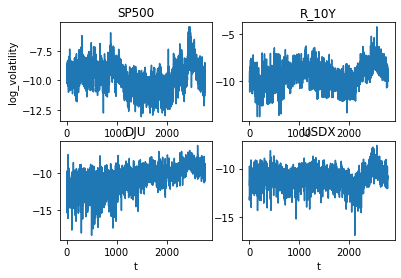

'Plutôt stationnaire'

In [ ]:
t,s1,s2,s3,s4 =log_vol['Date'].values, log_vol['SP500'].values,log_vol['R_10Y'].values,log_vol['DJUBSCOM'].values,log_vol['USDX'].values

fig, axs = plt.subplots(2,2)

axs[0,0].plot(s1)
axs[0, 0].set_title('SP500')
axs[0, 0].set_ylabel('log_volatility')
axs[0,1].plot(s2)
axs[0, 1].set_title('R_10Y')
axs[1,0].plot(s3)
axs[1, 0].set_title('DJU')
axs[1, 0].set_xlabel('t')
axs[1,1].plot(s4)
axs[1, 1].set_title('USDX')
axs[1, 1].set_xlabel('t')

plt.show()

"Plutôt stationnaire"

In [ ]:
data=log_vol.iloc[:,1:]
model = VAR(data)
results = model.fit(maxlags=50, ic='bic')        #On utilise le BIC pour trouver l'ordre (AIC trop grand ordre)


In [ ]:
def fevd_result(r,h):
    "Returns forecast error variance decomposition h step ahead for a model"
    fevd = r.fevd(h)
    tableau=np.zeros((fevd.neqs,fevd.neqs))
    for i in range(fevd.neqs):
        tableau[i]=fevd.decomp[i][fevd.periods-1]*100
    d=pd.DataFrame(tableau,index=[fevd.names[j] for j in range(fevd.neqs)],columns=[fevd.names[j] for j in range(fevd.neqs)] )
    return(d)


print("fevd : \n",fevd_result(results,10))

fevd : 
               SP500      R_10Y   DJUBSCOM       USDX
SP500     99.423109   0.323736   0.159558   0.093597
R_10Y      9.593782  89.225180   0.953528   0.227510
DJUBSCOM   0.645505   1.885210  96.927096   0.542188
USDX       5.354920   4.292691   0.522770  89.829618


In [ ]:
# Fiabilité de la formule
def fevd_verif(results,h):
    "On souhaite vérifier les valeurs données par statsmodels"
    m=results.neqs
    A=results.ma_rep(100)                            # Récupère les matrices de coefficient Ai jusqu'à 100 dans le modèle MA(infini)
    Σ=results.sigma_u                                # Récupère la matrice des covariances des bruits blancs
    theta=results.orth_ma_rep(100)                   # Récupère les matrices des coefficients theta orthogonalisée
    E = np.eye(m)
    w=np.zeros((m,m))
    for i in range(m):
        for j in range (m):
            a=0
            MSE=0
            for l in range (h):
                a+=(E[i]@theta[l]@E[j])**2
                MSE+=E[i]@A[l]@Σ@np.transpose(A[l])@E[i]
            w[i,j]= a/MSE
    return w*100

print('Différence des deux résultats \n ')
fevd_verif(results,10)-fevd_result(results,10)



Différence des deux résultats 
 


,SP500,R_10Y,DJUBSCOM,USDX
SP500,0.0,0.0,0.0,0.0
R_10Y,0.0,0.0,0.0,0.0
DJUBSCOM,0.0,0.0,0.0,0.0
USDX,0.0,0.0,0.0,0.0


In [ ]:
#Test robustesse sur h
print("Robustesse en faisant varier h \n\n\n")
for h in range(5,50,5):
    print(f"h={h} \n",fevd_result(results,h),"\n\n")

print("Le modèle est robuste pour des variations de h")

Robustesse en faisant varier h 



h=5 
               SP500      R_10Y   DJUBSCOM       USDX
SP500     99.727308   0.205798   0.023868   0.043026
R_10Y      7.385682  91.941037   0.530900   0.142382
DJUBSCOM   0.748790   0.696235  98.295729   0.259246
USDX       4.210109   3.679657   0.163906  91.946328 


h=10 
               SP500      R_10Y   DJUBSCOM       USDX
SP500     99.423109   0.323736   0.159558   0.093597
R_10Y      9.593782  89.225180   0.953528   0.227510
DJUBSCOM   0.645505   1.885210  96.927096   0.542188
USDX       5.354920   4.292691   0.522770  89.829618 


h=15 
               SP500      R_10Y   DJUBSCOM       USDX
SP500     99.153047   0.405105   0.306424   0.135424
R_10Y     11.273162  87.034496   1.406621   0.285721
DJUBSCOM   0.602343   3.205282  95.463284   0.729091
USDX       6.240270   4.819526   0.814968  88.125235 


h=20 
               SP500      R_10Y   DJUBSCOM       USDX
SP500     98.916474   0.475280   0.438497   0.169749
R_10Y     12.602444  85.2542

In [ ]:
#Test robustesse sur l'ordre
for ordre in range(2,10):
    results = model.fit(ordre)  
    print(f"p={ordre} \n\n",fevd_result(results,20),"\n\n")      
print("Le modèle est également robuste lorsque l'on change l'ordre")

p=2 

               SP500      R_10Y   DJUBSCOM       USDX
SP500     98.986197   0.362414   0.436656   0.214733
R_10Y     16.346136  80.051907   3.290117   0.311840
DJUBSCOM   0.250003   5.383435  93.154857   1.211705
USDX       9.054693   5.185730   2.175826  83.583751 


p=3 

               SP500      R_10Y   DJUBSCOM       USDX
SP500     98.422729   0.704393   0.679854   0.193025
R_10Y     15.789668  81.314883   2.607185   0.288265
DJUBSCOM   0.494033   5.441189  93.208286   0.856492
USDX       8.595171   5.852695   1.798757  83.753377 


p=4 

               SP500      R_10Y   DJUBSCOM       USDX
SP500     98.469201   0.785068   0.621786   0.123945
R_10Y     14.523006  82.724749   2.614598   0.137647
DJUBSCOM   0.460513   5.905864  92.745461   0.888162
USDX       7.930502   6.212363   1.621331  84.235805 


p=5 

               SP500      R_10Y   DJUBSCOM       USDX
SP500     98.563676   0.673298   0.621792   0.141235
R_10Y     13.202169  84.410819   2.170787   0.216226
DJUBSCOM 

In [ ]:
#Test robustesse en changeant l'ordre des colonnes

for i in range(len(data.columns)):
    dat=data[np.random.permutation(data.columns)]
    model = VAR(dat)
    results = model.fit(maxlags=50, ic='bic')
    print(fevd_result(results,10).loc[['SP500','R_10Y','DJUBSCOM','USDX'],['SP500','R_10Y','DJUBSCOM','USDX']],"\n\n")

print('modèle également résistant au changement d \'ordre')

              SP500      R_10Y   DJUBSCOM       USDX
SP500     99.423109   0.302864   0.160545   0.113481
R_10Y      9.593782  85.887941   1.111539   3.406738
DJUBSCOM   0.645505   1.265400  96.877000   1.212095
USDX       5.354920   0.553060   0.323770  93.768249 


              SP500      R_10Y   DJUBSCOM       USDX
SP500     99.423109   0.297213   0.166196   0.113481
R_10Y      9.593782  86.050012   0.949467   3.406738
DJUBSCOM   0.645505   1.490772  96.651627   1.212095
USDX       5.354920   0.555055   0.321775  93.768249 


              SP500      R_10Y   DJUBSCOM       USDX
SP500     99.423109   0.323736   0.159558   0.093597
R_10Y      9.593782  89.225180   0.953528   0.227510
DJUBSCOM   0.645505   1.885210  96.927096   0.542188
USDX       5.354920   4.292691   0.522770  89.829618 


              SP500      R_10Y   DJUBSCOM       USDX
SP500     92.131030   7.615815   0.166196   0.086959
R_10Y      1.270290  97.548672   0.949467   0.231570
DJUBSCOM   0.526645   2.004070  96.65

In [ ]:
## Fenêtrage sur 200 jours, les résultats obtenu à partir de la fevd déja implementé, p=6

tau=200
h=10
p=6
k=len(data.columns)
net_contribution=[[],[],[],[]]
for t0 in range(len(data)-tau):
    model_rd = VAR(data.iloc[t0:t0+tau])
    results_rd = model_rd.fit(p)
    df=fevd_result(results_rd,h)
    df=df.values
    for l in range (k):
        a=0
        b=0
        for j in range (k):
            if j!=l:
                a+=df[l,j]
                b+=df[j,l]
        net_contribution[l].append(b-a)




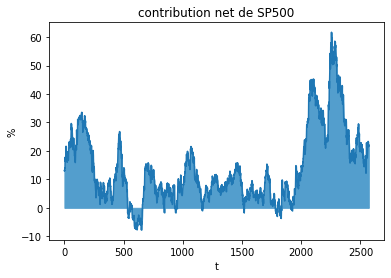

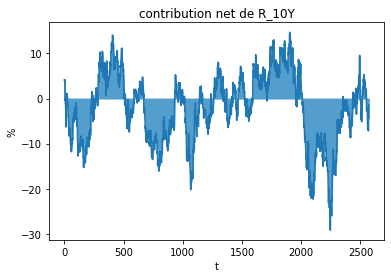

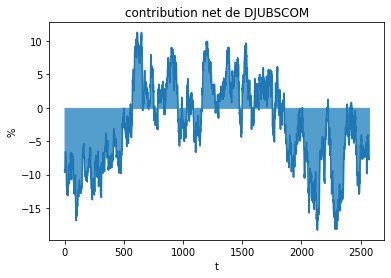

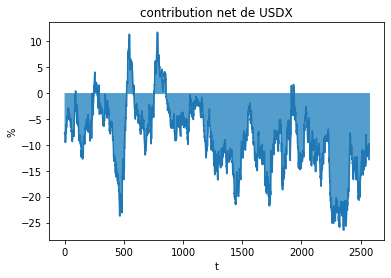

In [ ]:

titles=['SP500','R_10Y','DJUBSCOM','USDX']
for i in range (0,4):
    plt.figure()
    plt.plot(np.arange(len(net_contribution[0])),net_contribution[i])
    plt.fill_between(np.arange(len(net_contribution[0])), net_contribution[i], color='#539ecd')
    plt.ylabel("%")
    plt.xlabel("t")
    plt.title('contribution net de '+titles[i])

In [ ]:
#Fevd généralisé

def fevd_gen(results,h):
    A=results.ma_rep(100)                  
    Σ=results.sigma_u
    m=results.neqs
    𝛉 = np.zeros((m,m))
    E = np.eye(m)
    for i in range(m):
        for j in range (m):
            a=0
            b=0
            for l in range (h):
                a+=(E[i]@A[l]@Σ@E[j])**2
                b+=E[i]@A[l]@Σ@np.transpose(A[l])@E[i]
            a=a*(Σ.iloc[i,i]**(-2))
            𝛉[i,j]= a/b
    𝛉=pd.DataFrame(𝛉,index=results.names,columns=results.names)
    return 𝛉.div(𝛉.sum(axis=1), axis=0)*100


h=10

print("FEVD avec la formule généralisée \n\n",fevd_gen(results,h),"\n\n On obtient une matrice plus proche de celle postée par le prof")

NameError: ignored

In [ ]:
## Fenêtrage sur 200 jours, les résultats obtenu à partir de la fevd généralisée implementé, p=6


tau=200
h=15
p=6
k=len(data.columns)
net_contribution=[[],[],[],[]]
for t0 in range(len(data)-tau):
    model_rd = VAR(data.iloc[t0:t0+tau])
    results_rd = model_rd.fit(p)
    df=fevd_gen(results_rd,h)
    df=df.values
    for l in range (k):
        a=0
        b=0
        for j in range (k):
            if j!=l:
                a+=df[l,j]
                b+=df[j,l]
        net_contribution[l].append(b-a)




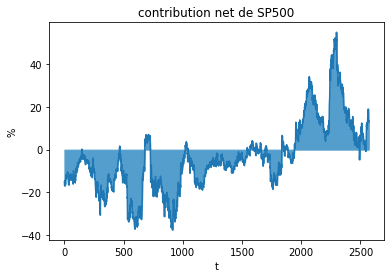

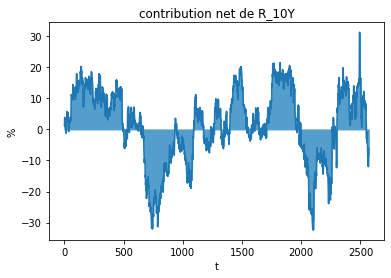

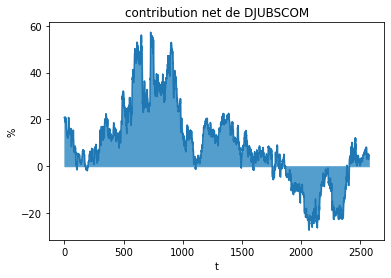

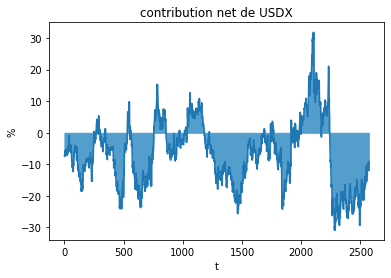

In [ ]:

titles=['SP500','R_10Y','DJUBSCOM','USDX']
for i in range (0,4):
    plt.figure()
    plt.plot(np.arange(len(net_contribution[0])),net_contribution[i])
    plt.fill_between(np.arange(len(net_contribution[0])), net_contribution[i], color='#539ecd')
    plt.ylabel("%")
    plt.xlabel("t")
    plt.title('contribution net de '+titles[i])

# Crypto Data

## resample Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from statsmodels import *
import statsmodels.tsa.vector_ar.vecm
from statsmodels.tsa.api import VECM
import pandas as pd
import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

dossiers=['bitmex2016','bitmex2017','bitmex2018-1','bitmex2018-2']
def fichier(dossier):
    listeFichiers = []
    for (repertoire, sousRepertoires, fichiers) in os.walk('CryptoData/CryptoData/'+dossier):
     listeFichiers.extend(fichiers)
    return listeFichiers


In [ ]:

## do not run this code !!!!!!
## it is just for demonstration !

dossier='bitmex2016'
if not os.path.exists(dossier):
  os.makedirs(dossier)
list_file=fichier(dossier)
frame=[]
for file in list_file:
  bitmex= pd.read_csv('CryptoData/CryptoData/'+dossier+'/'+file)
  bitmex=bitmex.iloc[:,[0,2]]
  bitmex['timestamp'] = pd.to_datetime(bitmex.timestamp, format='%Y-%m-%d %H:%M:%S')
  bitmex.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)
  bitmex.fillna(method='ffill', inplace=True)
  frame.append(bitmex.set_index('timestamp').resample('60S').pad().fillna(method='bfill'))
bitmex2016=pd.concat(frame)

In [ ]:
dossiers=['bitmex2017','bitmex2018-1','bitmex2018-2']
frame1=[bitmex2016]
for dossier in dossiers:
  list_file=fichier(dossier)
  for file in list_file:
    bitmex= pd.read_csv('CryptoData/CryptoData/'+dossier+'/'+file) 
    bitmex=bitmex.loc[bitmex['symbol'] == 'XBTUSD']
    bitmex=bitmex.iloc[:,[0,4]]
    bitmex.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)
    bitmex['timestamp'] = pd.to_datetime(bitmex.timestamp, format='%Y-%m-%dD%H:%M:%S.%f')
    bitmex.fillna(method='ffill', inplace=True)
    frame1.append(bitmex.set_index('timestamp').resample('60S').pad().fillna(method='bfill'))
bitmex=pd.concat(frame1)

In [ ]:
Kraken=pd.read_csv('CryptoData/CryptoData/KrakenUSD.csv.gz', header=None)
Kraken.columns = ['date', 'price', 'qty']
Kraken.pop('qty')
Kraken['date'] = pd.to_datetime(Kraken.date, unit='s')
Kraken=Kraken.drop_duplicates(subset=['date'], keep='last')
Kraken.fillna(method='ffill', inplace=True)
Kraken=a.set_index('date').resample('60S').pad()
Kraken.fillna(method='bfill', inplace=True)

In [ ]:
bitstamp=pd.read_csv('CryptoData/CryptoData/bitstampUSD.csv.gz', header=None)
bitstamp.columns = ['date', 'price', 'qty']
bitstamp.pop('qty')
bitstamp['date'] = pd.to_datetime(bitstamp.date, unit='s')
bitstamp=bitstamp.drop_duplicates(subset=['date'], keep='last')
bitstamp.fillna(method='ffill', inplace=True)
bitstamp=bitstamp.set_index('date').resample('60S').pad()
bitstamp.fillna(method='bfill', inplace=True)

In [ ]:
coinbase=pd.read_csv('CryptoData/CryptoData/coinbaseUSD.csv.gz', header=None)
coinbase.columns = ['date', 'price', 'qty']
coinbase.pop('qty')
coinbase['date'] = pd.to_datetime(coinbase.date, unit='s')
coinbase=coinbase.drop_duplicates(subset=['date'], keep='last')
coinbase.fillna(method='ffill', inplace=True)
coinbase=coinbase.set_index('date').resample('60S').pad()
coinbase.fillna(method='bfill', inplace=True)

In [ ]:
bitmex.columns=['date','bitmex']
bitmex.set_index('date',inplace=True)
bitstamp.set_index('date',inplace=True)
bitstamp.columns=['bitstamp']
Kraken.set_index('date',inplace=True)
Kraken.columns=['kraken']
coinbase.set_index('date',inplace=True)
coinbase.columns=['coinbase']

# concat and merge
frame=[bitstamp,kraken,coinbase]
dataframe=pd.concat(frame,axis=1)
bitmex.merge(dataframe, how='inner', left_index=True, right_index=True).to_csv('final_datframe.csv')

## VECM

In [ ]:
import statsmodels.tsa.vector_ar.vecm
from statsmodels.tsa.api import VECM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv('drive/MyDrive/dataframe.csv')
df

,date,bitmex,bitstamp,kraken,coinbase
0,2016-01-01 00:06:00,430.500,430.54,431.31,430.96
1,2016-01-01 00:07:00,430.500,432.52,431.31,431.18
2,2016-01-01 00:08:00,430.500,432.53,431.31,431.82
3,2016-01-01 00:09:00,430.875,432.53,431.31,431.52
4,2016-01-01 00:10:00,430.875,432.51,431.31,431.59
...,...,...,...,...,...
1571917,2018-12-31 23:55:00,3686.000,3684.85,3686.90,3684.74
1571918,2018-12-31 23:56:00,3689.000,3688.85,3685.90,3685.00
1571919,2018-12-31 23:57:00,3689.000,3686.92,3687.90,3685.01
1571920,2018-12-31 23:58:00,3689.000,3689.26,3688.70,3685.01


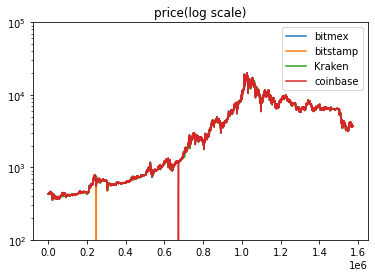

In [ ]:
plt.plot(df['bitmex'], label='bitmex')
plt.plot(df['bitstamp'],label='bitstamp')
plt.plot(df['kraken'], label='Kraken')
plt.plot(df['coinbase'], label='coinbase')
plt.yscale('log')
plt.ylim(10**2,10**5)
plt.title('price(log scale)')
plt.legend()

plt.show()

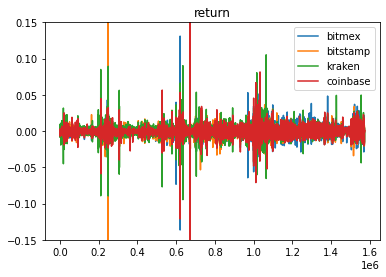

In [ ]:


plt.plot(np.log(df['bitmex']).diff(),label='bitmex')
plt.plot(np.log(df['bitstamp']).diff(),label='bitstamp')
plt.plot(np.log(df['kraken']).diff(),label='kraken')
plt.plot(np.log(df['coinbase']).diff(),label='coinbase')
plt.ylim(-0.15,0.15)
plt.title('return')
plt.legend()
plt.show()

In [ ]:
log_bitmex= pd.DataFrame(columns=['bitmex-kraken'])
log_bitmex['bitmex-kraken']=np.log(df['bitmex'])-np.log(df['kraken'])
log_bitmex['bitmex-bitstamp']=np.log(df['bitmex'])-np.log(df['bitstamp'])
log_bitmex['bitmex-coinbase']=np.log(df['bitmex'])-np.log(df['coinbase'])
log_bitmex

,bitmex-kraken,bitmex-bitstamp,bitmex-coinbase
0,-0.001880,-0.000093,-0.001068
1,-0.001880,-0.004681,-0.001578
2,-0.001880,-0.004704,-0.003062
3,-0.001009,-0.003834,-0.001496
4,-0.001009,-0.003787,-0.001658
...,...,...,...
1571917,-0.000244,0.000312,0.000342
1571918,0.000841,0.000041,0.001085
1571919,0.000298,0.000564,0.001082
1571920,0.000081,-0.000070,0.001082


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


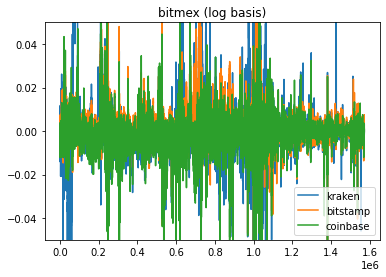

In [ ]:
plt.plot(log_bitmex['bitmex-kraken'],label='kraken')
plt.plot(log_bitmex['bitmex-bitstamp'],label='bitstamp')
plt.plot(log_bitmex['bitmex-coinbase'],label='coinbase')
plt.ylim(-0.05,0.05)
plt.title('bitmex (log basis)')
plt.legend()
plt.show()

In [ ]:
def f(n):
    m=datetime.date(2016,1,1)+datetime.timedelta(days = n)
    return str(m)

## nombre des jours est 1095
def logdata_day(n):
    day=f(n)
    data_day=df[(df['date']<f(n+1))&(df['date']>f(n))].set_index('date')
    return np.log(data_day)

def fevd_verif(results,h):
    "On souhaite vérifier les valeurs données par statsmodels"
    m=results.neqs
    A=results.ma_rep(100)                            # Récupère les matrices de coefficient Ai jusqu'à 100 dans le modèle MA(infini)
    Σ=results.sigma_u                                # Récupère la matrice des covariances des bruits blancs
    theta=results.orth_ma_rep(100)                   # Récupère les matrices des coefficients theta orthogonalisée
    E = np.eye(m)
    w=np.zeros((m,m))
    for i in range(m):
        for j in range (m):
            a=0
            MSE=0
            for l in range (h):
                a+=(E[i]@theta[l]@E[j])**2
                MSE+=E[i]@A[l]@Σ@np.transpose(A[l])@E[i]
            w[i,j]= a/MSE
    return w*100


  #Fevd généralisé

def fevd_gen(results,h):
    A=results.ma_rep(100)        # Récupère les matrices de coefficient Ai jusqu'à 100 dans le modèle MA(infini)           
    Σ=results.sigma_u             # Récupère la matrice des covariances des bruits blancs
    m=results.neqs               # Récupère les matrices des coefficients theta orthogonalisée
    𝛉 = np.zeros((m,m))
    E = np.eye(m)
    for i in range(m):
        for j in range (m):
            a=0
            b=0
            for l in range (h):
                a+=(E[i]@A[l]@Σ@E[j])**2
                b+=E[i]@A[l]@Σ@np.transpose(A[l])@E[i]
            a=a*(Σ[i,i]**(-2))
            𝛉[i,j]= a/b
    𝛉=pd.DataFrame(𝛉,index=results.names,columns=results.names)
    return 𝛉.div(𝛉.sum(axis=1), axis=0)*100

In [ ]:
lag_order = statsmodels.tsa.vector_ar.vecm.select_order(data=logdata_day(1), maxlags=10, deterministic="ci", seasons=4)
lag_order.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

,AIC,BIC,FPE,HQIC
0,-61.02,-60.88,3.172e-27,-60.97
1,-61.11,-60.92*,2.885e-27,-61.04
2,-61.16*,-60.91,2.748e-27*,-61.06*
3,-61.15,-60.84,2.763e-27,-61.04
4,-61.14,-60.77,2.804e-27,-61.00
5,-61.13,-60.70,2.816e-27,-60.97
6,-61.13,-60.64,2.818e-27,-60.95
7,-61.12,-60.57,2.850e-27,-60.92
8,-61.13,-60.51,2.841e-27,-60.90
9,-61.12,-60.45,2.863e-27,-60.87


In [ ]:
rank_test = statsmodels.tsa.vector_ar.vecm.select_coint_rank(logdata_day(1), 0, 3, method="trace")
                              
rank_test.rank

4

In [ ]:
model = VECM(logdata_day(1).iloc[:,1:], deterministic="ci", seasons=4,k_ar_diff=lag_order.bic,coint_rank=rank_test.rank)
vecm_res = model.fit()
vecm_res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:1416: RuntimeWarning: divide by zero encountered in true_divide
  return self.det_coef_coint / self.stderr_det_coef_coint


,coef,std err,z,P>|z|,[0.025,0.975]
season1,6.26e-05,5.93e-05,1.055,0.291,-5.36e-05,0.000
season2,8.609e-05,5.94e-05,1.450,0.147,-3.03e-05,0.000
season3,-1.328e-05,5.93e-05,-0.224,0.823,-0.000,0.000
L1.bitstamp,-0.2230,0.026,-8.500,0.000,-0.274,-0.172
L1.kraken,-0.0053,0.039,-0.135,0.892,-0.082,0.071
L1.coinbase,0.1459,0.065,2.242,0.025,0.018,0.274
,coef,std err,z,P>|z|,[0.025,0.975]
season1,2.335e-05,4.03e-05,0.580,0.562,-5.55e-05,0.000
season2,5.169e-05,4.03e-05,1.283,0.200,-2.73e-05,0.000
season3,4.617e-05,4.02e-05,1.147,0.251,-3.27e-05,0.000


In [ ]:
h=60

print("FEVD avec la formule généralisée \n\n",fevd_gen(vecm_res,h))

FEVD avec la formule généralisée 

              bitmex   bitstamp     kraken   coinbase
bitmex    94.972877   0.153226   3.360099   1.513798
bitstamp   5.120524  83.735480   0.031536  11.112459
kraken     3.676430   4.741200  90.697954   0.884417
coinbase  17.984198  51.648957   0.306500  30.060345


In [ ]:
p=1
k=4
h=60
net_contribution=[[],[],[],[]]
non_valid_day=[]
total_contribution
for n in range(1096):
    try: 
        model=VECM(logdata_day(n), deterministic="ci", seasons=4,k_ar_diff=lag_order.bic,coint_rank=rank_test.rank)
        results= model.fit()
        d=fevd_gen(results,h).values
        c=0
        for l in range (k):
            a=0
            b=0
            for j in range (k):
                if j!=l:
                    a+=d[l,j]
                    b+=d[j,l]
                    c+=d[j,l]
            net_contribution[l].append(b-a)
        total_contribution.append(c)
    except :
        non_valid_day.append(n)
print(non_valid_day)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 994]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


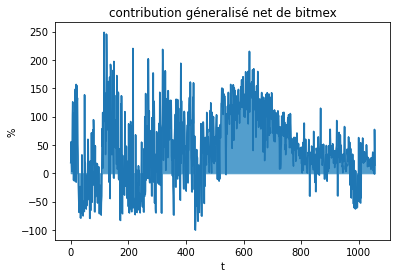

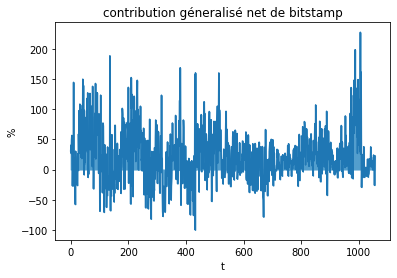

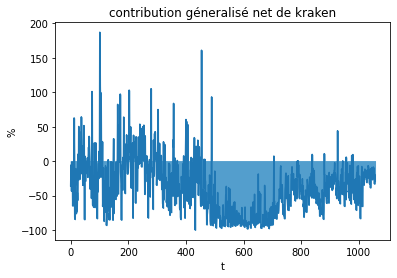

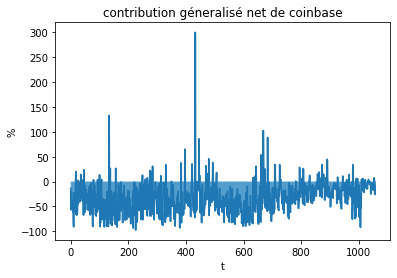

In [ ]:

titles=['bitmex','bitstamp','kraken','coinbase']
for i in range (0,4):
    plt.figure()
    plt.plot(np.arange(len(net_contribution[0])),net_contribution[i])
    plt.fill_between(np.arange(len(net_contribution[0])), net_contribution[i], color='#539ecd')
    plt.ylabel("%")
    plt.xlabel("t")
    plt.title('contribution géneralisé net de '+titles[i])

(0.0, 400.0)

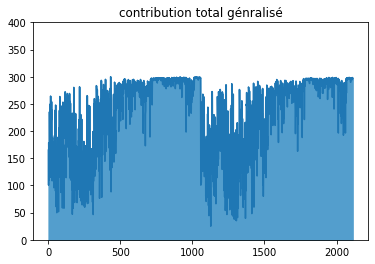

In [54]:
plt.figure()
plt.plot(np.arange(len(total_contribution)),total_contribution)
plt.fill_between(np.arange(len(total_contribution)), total_contribution, color='#539ecd')
plt.title('contribution total génralisé')
plt.ylim(0,400)

In [51]:
p=1
k=4
h=60
net_contribution_normal=[[],[],[],[]]
non_valid_day=[]
total_contribution_normal=[]
for n in range(1096):
    try: 
        model=VECM(logdata_day(n), deterministic="ci", seasons=4,k_ar_diff=lag_order.bic,coint_rank=rank_test.rank)
        results= model.fit()
        d=fevd_verif(results,h)
        c=0
        for l in range (k):
            a=0
            b=0
            for j in range (k):
                if j!=l:
                    a+=d[l,j]
                    b+=d[j,l]
                    c+=d[j,l]
            net_contribution_normal[l].append(b-a)
        total_contribution_normal.append(c)
    except :
        non_valid_day.append(n)
print(non_valid_day)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 994]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


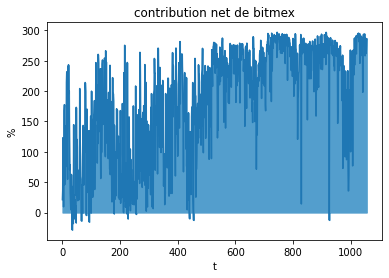

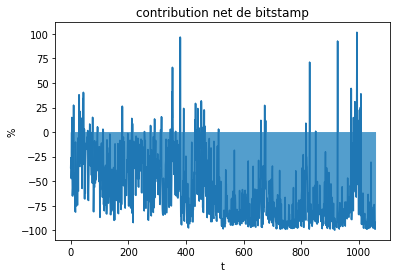

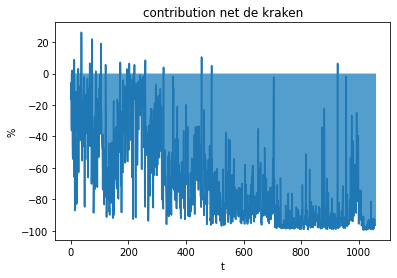

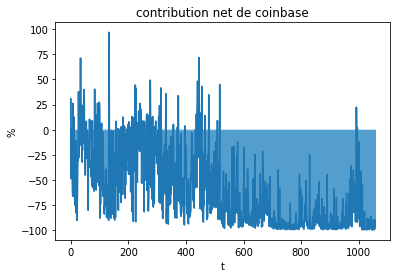

In [52]:
titles=['bitmex','bitstamp','kraken','coinbase']
for i in range (0,4):
    plt.figure()
    plt.plot(np.arange(len(net_contribution_normal[0])),net_contribution_normal[i])
    plt.fill_between(np.arange(len(net_contribution_normal[0])), net_contribution_normal[i], color='#539ecd')
    plt.ylabel("%")
    plt.xlabel("t")
    plt.title('contribution net de '+titles[i])

Text(0.5, 1.0, 'contribution total')

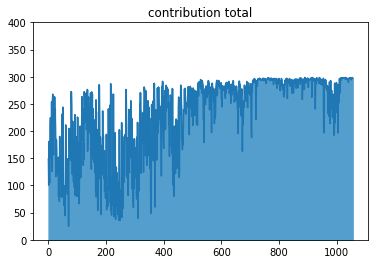

In [53]:
plt.figure()
plt.plot(np.arange(len(total_contribution_normal)),total_contribution_normal)
plt.fill_between(np.arange(len(total_contribution_normal)), total_contribution_normal, color='#539ecd')
plt.ylim(0,400)
plt.title('contribution total')

# HF

## Import data


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving HFData.zip to HFData.zip


In [ ]:
from zipfile import ZipFile
file_name='/content/HFData.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sn
HK_stocks={}
T_stocks={}
N_stocks={}
OQ_stocks={}
L_stocks={}
PA_stocks={}

for file in os.listdir("HFData/"):
    if file.endswith(".HK.csv") :
        HK_stocks[file]=pd.read_csv('HFData/'+file).iloc[:,1:]
    elif file.endswith(".T.csv"):
        T_stocks[file]=pd.read_csv('HFData/'+file).iloc[:,1:]
    elif file.endswith(".N.csv"):
        N_stocks[file]=pd.read_csv('HFData/'+file).iloc[:,1:] 
    elif file.endswith(".OQ.csv"):
        OQ_stocks[file]=pd.read_csv('HFData/'+file).iloc[:,1:]
    elif file.endswith(".L.csv"):
        L_stocks[file]=pd.read_csv('HFData/'+file).iloc[:,1:]
    elif file.endswith(".PA.csv"):
        PA_stocks[file]=pd.read_csv('HFData/'+file).iloc[:,1:]


# Modification des données trop anciennes
pd.options.mode.chained_assignment = None
for i in L_stocks:
    L_stocks[i]['volatility'].loc[L_stocks[i]['volatility']<0]=1e-6
    L_stocks[i]['spread'].loc[L_stocks[i]['spread']<0]=np.NaN
for i in HK_stocks:
    HK_stocks[i]['volatility'].loc[HK_stocks[i]['volatility']<0]=1e-6

del T_stocks['8411.T.csv']

## Affichage données bruts

### Hong Kong

In [ ]:
donnee='0002.HK.csv'
df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
df['ts']=df['ts'].apply(lambda x: x[-8:-3])
time=df['ts'].loc[df['date']==df['date'][0]]

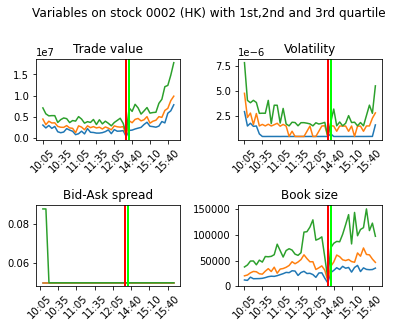

Trait rouge : 12h25
Trait vert : 14h35


In [ ]:
#Visualisation de la médiane,quartiles d'un stock sur un mois

def mean_month(df):
    d=df[['ts','spread','tradedValue','volatility','bookSize']].loc[df['ts']==df['ts'][0]].quantile([0.25,0.5,0.75])
    for i in range(1,len(time)):
        d=pd.concat([d,df[['ts','spread','tradedValue','volatility','bookSize']].loc[df['ts']==df['ts'][i]].quantile([0.25,0.5,0.75])],axis=0)
    f_quart=d.loc[d.index==0.25]
    s_quart=d.loc[d.index==0.5]
    t_quart=d.loc[d.index==0.75]
    f_quart.index=np.arange(len(time))
    s_quart.index=np.arange(len(time))
    t_quart.index=np.arange(len(time))
    return f_quart,s_quart,t_quart

q=mean_month(df)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=6
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=28, linewidth=2, color='r')
axs[0,0].axvline(x=29, linewidth=2, color='lime')
axs[0,1].axvline(x=28, linewidth=2, color='r')
axs[0,1].axvline(x=29, linewidth=2, color='lime')
axs[1,0].axvline(x=28, linewidth=2, color='r')
axs[1,0].axvline(x=29, linewidth=2, color='lime')
axs[1,1].axvline(x=28, linewidth=2, color='r')
axs[1,1].axvline(x=29, linewidth=2, color='lime')


axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on stock {donnee[:4]} ({donnee[5:7]}) with 1st,2nd and 3rd quartile")
plt.show()

print("Trait rouge : 12h25")
print("Trait vert : 14h35")

#### Autres pas utile pour la présentation


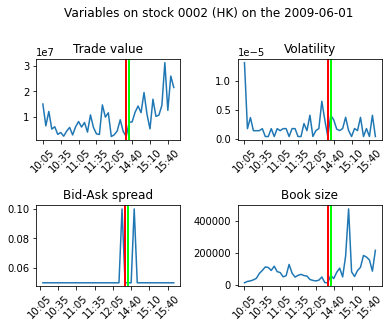

In [ ]:
def affichage_Asia(df,date,tau,donnee):
    
    d=df.loc[df['date']==date]
    n=len(d)
    d.index=np.arange(n)
    time=d['ts']
    Spread,TradedValue, volatility, bookSize=d['spread'],d['tradedValue'],d['volatility'],d['bookSize']
    fig,axs=plt.subplots(2,2)
    axs[0,0].plot(TradedValue)
    axs[0,1].plot(volatility)
    axs[1,0].plot(Spread)
    axs[1,1].plot(bookSize)
    axs[0,0].set_xticks(range(0,n,tau))
    axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[0,1].set_xticks(range(0,n,tau))
    axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[1,0].set_xticks(range(0,n,tau))
    axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[1,1].set_xticks(range(0,n,tau))
    axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
    
    axs[0,0].axvline(x=28, linewidth=2, color='r')
    axs[0,0].axvline(x=29, linewidth=2, color='lime')
    axs[0,1].axvline(x=28, linewidth=2, color='r')
    axs[0,1].axvline(x=29, linewidth=2, color='lime')
    axs[1,0].axvline(x=28, linewidth=2, color='r')
    axs[1,0].axvline(x=29, linewidth=2, color='lime')
    axs[1,1].axvline(x=28, linewidth=2, color='r')
    axs[1,1].axvline(x=29, linewidth=2, color='lime')
    
    axs[0, 0].set_title('Trade value')
    axs[0, 1].set_title('Volatility')
    axs[1, 0].set_title('Bid-Ask spread')
    axs[1, 1].set_title('Book size')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.8)
    fig.suptitle(f"Variables on stock {donnee[:4]} ({donnee[5:7]}) on the {date}")
    plt.show()
for i in range(1,2):
    affichage_Asia(df,f'2009-06-0{i}',6,donnee)

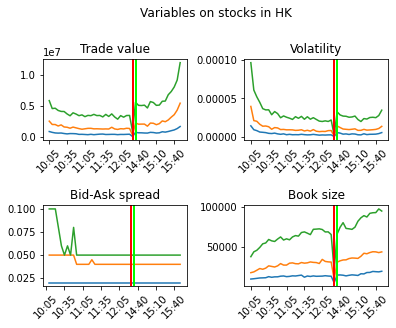

In [ ]:
#Visualisation sur tous les stocks HK

Moy_A=[i for i in HK_stocks.values()]
Moy_A=pd.concat(Moy_A)
Moy_A['ts']=Moy_A['ts'].apply(lambda x: x[-8:-3])
Moy_A.index=np.arange(len(Moy_A))


q=mean_month(Moy_A)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=6
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=28, linewidth=2, color='r')
axs[0,0].axvline(x=29, linewidth=2, color='lime')
axs[0,1].axvline(x=28, linewidth=2, color='r')
axs[0,1].axvline(x=29, linewidth=2, color='lime')
axs[1,0].axvline(x=28, linewidth=2, color='r')
axs[1,0].axvline(x=29, linewidth=2, color='lime')
axs[1,1].axvline(x=28, linewidth=2, color='r')
axs[1,1].axvline(x=29, linewidth=2, color='lime')


axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on stocks in HK")
plt.show()

### Tokyo

In [ ]:
donnee='9983.T.csv'
df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
df['ts']=df['ts'].apply(lambda x: x[-8:-3])
time=df['ts'].loc[df['date']==df['date'][0]]

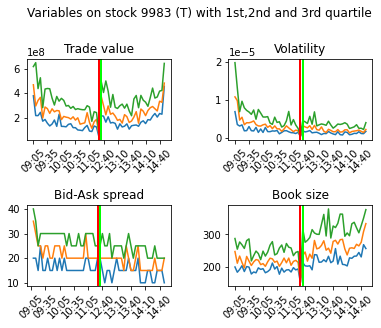

Trait rouge : 11h25
Trait vert : 12h35


In [ ]:
#Visualisation de la médiane,quartiles d'un stock sur un mois

q=mean_month(df)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=6
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=28, linewidth=2, color='r')
axs[0,0].axvline(x=29, linewidth=2, color='lime')
axs[0,1].axvline(x=28, linewidth=2, color='r')
axs[0,1].axvline(x=29, linewidth=2, color='lime')
axs[1,0].axvline(x=28, linewidth=2, color='r')
axs[1,0].axvline(x=29, linewidth=2, color='lime')
axs[1,1].axvline(x=28, linewidth=2, color='r')
axs[1,1].axvline(x=29, linewidth=2, color='lime')


axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on stock {donnee[:4]} ({donnee[5:6]}) with 1st,2nd and 3rd quartile")
plt.show()

print("Trait rouge : 11h25")
print("Trait vert : 12h35")

#### Autre inutile

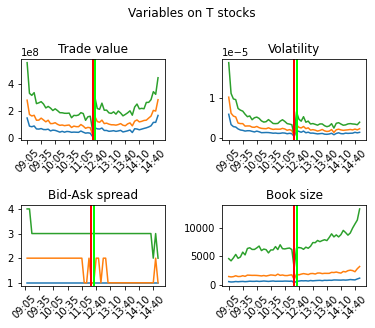

In [ ]:
#Visualisation sur tous les stocks T
Moy_A=[i for i in T_stocks.values()]
Moy_A=pd.concat(Moy_A)
Moy_A['ts']=Moy_A['ts'].apply(lambda x: x[-8:-3])
Moy_A.index=np.arange(len(Moy_A))


q=mean_month(Moy_A)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=6
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=28, linewidth=2, color='r')
axs[0,0].axvline(x=29, linewidth=2, color='lime')
axs[0,1].axvline(x=28, linewidth=2, color='r')
axs[0,1].axvline(x=29, linewidth=2, color='lime')
axs[1,0].axvline(x=28, linewidth=2, color='r')
axs[1,0].axvline(x=29, linewidth=2, color='lime')
axs[1,1].axvline(x=28, linewidth=2, color='r')
axs[1,1].axvline(x=29, linewidth=2, color='lime')


axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on T stocks ")
plt.show()

### New York

In [ ]:
donnee='BHP.N.csv'
df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
df['ts']=df['ts'].apply(lambda x: x[-8:-3])
time=df['ts'].loc[df['date']==df['date'][0]]

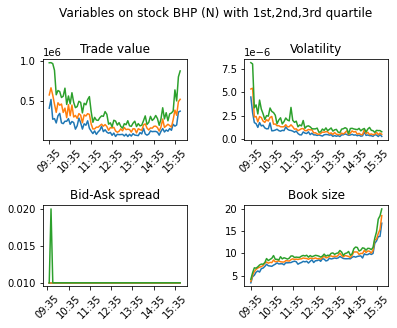

In [ ]:
#Visualisation de la médiane,quartiles d'un stock sur un mois
q=mean_month(df)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=12
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on stock {donnee[:3]} ({donnee[4:5]}) with 1st,2nd,3rd quartile")
plt.show()

#### Autre inutile

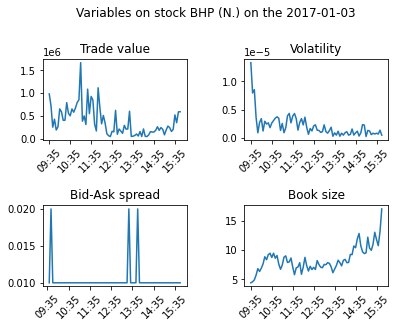

In [ ]:

def affichage_America(df,date,tau,donnee):
    
    d=df.loc[df['date']==date]
    n=len(d)
    d.index=np.arange(n)
    time=d['ts']
    Spread,TradedValue, volatility, bookSize=d['spread'],d['tradedValue'],d['volatility'],d['bookSize']
    fig,axs=plt.subplots(2,2)
    axs[0,0].plot(TradedValue)
    axs[0,1].plot(volatility)
    axs[1,0].plot(Spread)
    axs[1,1].plot(bookSize)
    axs[0,0].set_xticks(range(0,n,tau))
    axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[0,1].set_xticks(range(0,n,tau))
    axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[1,0].set_xticks(range(0,n,tau))
    axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[1,1].set_xticks(range(0,n,tau))
    axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

    axs[0, 0].set_title('Trade value')
    axs[0, 1].set_title('Volatility')
    axs[1, 0].set_title('Bid-Ask spread')
    axs[1, 1].set_title('Book size')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.8)
    fig.suptitle(f"Variables on stock {donnee[:3]} ({donnee[4:6]}) on the {date}")
    plt.show()
for i in range(3,4):
    affichage_America(df,f'2017-01-0{i}',12,donnee)

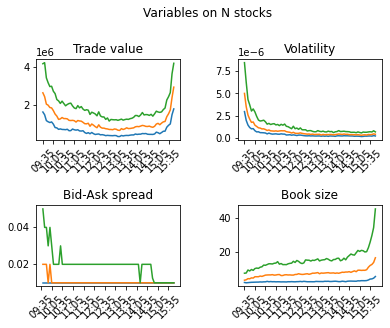

In [ ]:
#Visualisation sur tous les stocks N
Moy_A=[i for i in N_stocks.values()]
Moy_A=pd.concat(Moy_A)
Moy_A['ts']=Moy_A['ts'].apply(lambda x: x[-8:-3])
Moy_A.index=np.arange(len(Moy_A))


q=mean_month(Moy_A)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=6
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on N stocks ")
plt.show()

###Nasdaq

In [ ]:
donnee='AMD.OQ.csv'
df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
df['ts']=df['ts'].apply(lambda x: x[-8:-3])
time=df['ts'].loc[df['date']==df['date'][0]]

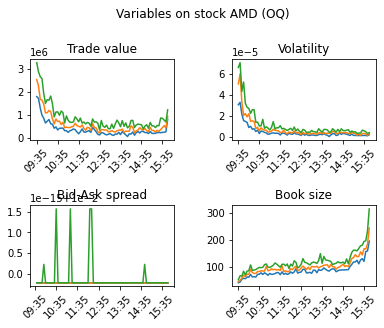

In [ ]:
#Visualisation de la médiane,quartiles d'un stock sur un mois
q=mean_month(df)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=12
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on stock {donnee[:3]} ({donnee[4:6]})")
plt.show()

#### Autre inutile

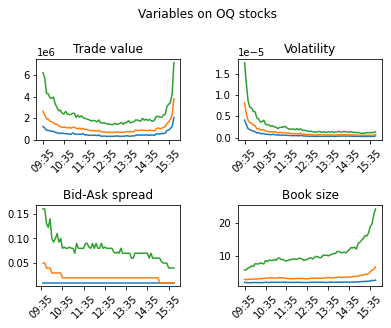

In [ ]:
#Visualisation sur tous les stocks OQ
Moy_A=[i for i in OQ_stocks.values()]
Moy_A=pd.concat(Moy_A)
Moy_A['ts']=Moy_A['ts'].apply(lambda x: x[-8:-3])
Moy_A.index=np.arange(len(Moy_A))


q=mean_month(Moy_A)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=12
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on OQ stocks ")
plt.show()

###Paris

In [ ]:
donnee='ALSO.PA.csv'
df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
df['ts']=df['ts'].apply(lambda x: x[-8:-3])
time=df['ts'].loc[df['date']==df['date'][0]]

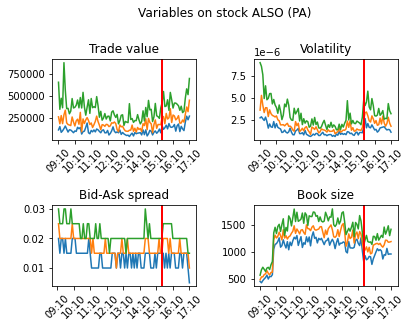

Trait rouge : ouverture des marchés américains


In [ ]:
#Visualisation de la médiane,quartiles d'un stock sur un mois
q=mean_month(df)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=12
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=76, linewidth=2, color='r')
axs[0,1].axvline(x=76, linewidth=2, color='r')
axs[1,0].axvline(x=76, linewidth=2, color='r')
axs[1,1].axvline(x=76, linewidth=2, color='r')

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on stock {donnee[:4]} ({donnee[5:7]})")
plt.show()
print('Trait rouge : ouverture des marchés américains')

#### Autre inutile

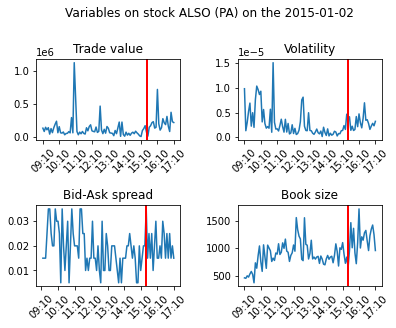

In [ ]:
#Visualisation du stock sur un jour
def affichage_Europa(df,date,tau,donnee):
    
    d=df.loc[df['date']==date]
    n=len(d)
    d.index=np.arange(n)
    time=d['ts']
    Spread,TradedValue, volatility, bookSize=d['spread'],d['tradedValue'],d['volatility'],d['bookSize']
    fig,axs=plt.subplots(2,2)
    axs[0,0].plot(TradedValue)
    axs[0,1].plot(volatility)
    axs[1,0].plot(Spread)
    axs[1,1].plot(bookSize)
    axs[0,0].set_xticks(range(0,n,tau))
    axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[0,1].set_xticks(range(0,n,tau))
    axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[1,0].set_xticks(range(0,n,tau))
    axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
    axs[1,1].set_xticks(range(0,n,tau))
    axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
    
    axs[0,0].axvline(x=76, linewidth=2, color='r')
    axs[0,1].axvline(x=76, linewidth=2, color='r')
    axs[1,0].axvline(x=76, linewidth=2, color='r')
    axs[1,1].axvline(x=76, linewidth=2, color='r')
    
    axs[0, 0].set_title('Trade value')
    axs[0, 1].set_title('Volatility')
    axs[1, 0].set_title('Bid-Ask spread')
    axs[1, 1].set_title('Book size')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.8)
    fig.suptitle(f"Variables on stock {donnee[:4]} ({donnee[5:7]}) on the {date}")
    plt.show()
affichage_Europa(df,f'2015-01-02',12,donnee)




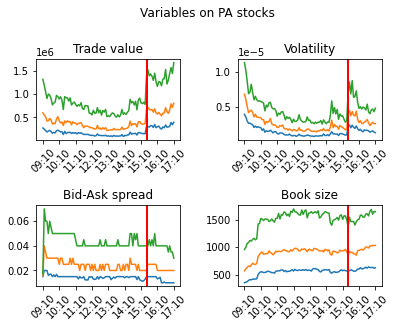

In [ ]:
#Visualisation sur tous les stocks PA
Moy_A=[i for i in PA_stocks.values()]
Moy_A=pd.concat(Moy_A)
Moy_A['ts']=Moy_A['ts'].apply(lambda x: x[-8:-3])
Moy_A.index=np.arange(len(Moy_A))


q=mean_month(Moy_A)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=12
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=76, linewidth=2, color='r')
axs[0,1].axvline(x=76, linewidth=2, color='r')
axs[1,0].axvline(x=76, linewidth=2, color='r')
axs[1,1].axvline(x=76, linewidth=2, color='r')

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on PA stocks ")
plt.show()

### London

In [ ]:
donnee='ABF.L.csv'
df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
df['ts']=df['ts'].apply(lambda x: x[-8:-3])
time=df['ts'].loc[df['date']==df['date'][0]]

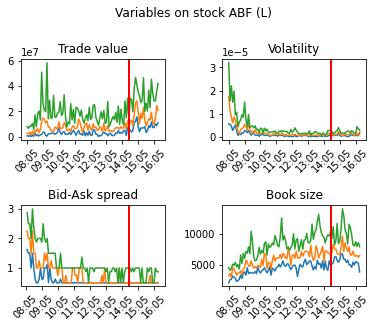

Trait rouge : Ouverture des marchés américains


In [ ]:
#Visualisation de la médiane,quartiles d'un stock sur un mois
q=mean_month(df)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=12
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=77, linewidth=2, color='r')
axs[0,1].axvline(x=77, linewidth=2, color='r')
axs[1,0].axvline(x=77, linewidth=2, color='r')
axs[1,1].axvline(x=77, linewidth=2, color='r')

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on stock {donnee[:3]} ({donnee[4:5]})")
plt.show()
print('Trait rouge : Ouverture des marchés américains')

####Autre inutile

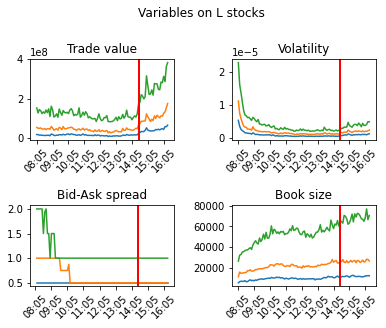

In [ ]:
#Visualisation sur tous les stocks L
Moy_A=[i for i in L_stocks.values()]
Moy_A=pd.concat(Moy_A)
Moy_A['ts']=Moy_A['ts'].apply(lambda x: x[-8:-3])
Moy_A.index=np.arange(len(Moy_A))


q=mean_month(Moy_A)
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=12
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=77, linewidth=2, color='r')
axs[0,1].axvline(x=77, linewidth=2, color='r')
axs[1,0].axvline(x=77, linewidth=2, color='r')
axs[1,1].axvline(x=77, linewidth=2, color='r')

axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"Variables on L stocks ")
plt.show()


## Stationarisation

In [ ]:
#Stationarisation
def stationnaire(df):
    time=df['ts'].loc[df['date']==df['date'][0]]
    d=df.copy()
    for i in d.iloc[:,-4:]:
        d.loc[d[i]<=0]=1e-6
        d[i]=np.log(d[i])
        for j in range(len(time)):
            d[i].loc[df['ts']==df['ts'][j]]-=(d[i].loc[df['ts']==df['ts'][j]]).mean()
    return d

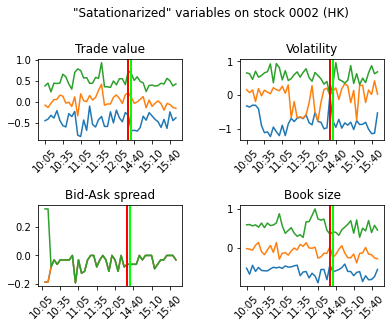

In [ ]:
#Stationarized data
donnee='0002.HK.csv'
df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
df['ts']=df['ts'].apply(lambda x: x[-8:-3])
time=df['ts'].loc[df['date']==df['date'][0]]
q=mean_month(stationnaire(df))
q1,q2,q3=q[0],q[1],q[2]
n=len(time)
tau=6
Spread1,TradedValue1, volatility1, bookSize1=q1['spread'],q1['tradedValue'],q1['volatility'],q1['bookSize']
Spread2,TradedValue2, volatility2, bookSize2=q2['spread'],q2['tradedValue'],q2['volatility'],q2['bookSize']
Spread3,TradedValue3, volatility3, bookSize3=q3['spread'],q3['tradedValue'],q3['volatility'],q3['bookSize']
fig,axs=plt.subplots(2,2)

axs[0,0].plot(TradedValue1,label='25% quantile')
axs[0,0].plot(TradedValue2,label='50% quantile')
axs[0,0].plot(TradedValue3,label='75% quantile')
axs[0,1].plot(volatility1,label='25% quantile')
axs[0,1].plot(volatility2,label='50% quantile')
axs[0,1].plot(volatility3,label='75% quantile')
axs[1,0].plot(Spread1,label='25% quantile')
axs[1,0].plot(Spread2,label='50% quantile')
axs[1,0].plot(Spread3,label='75% quantile')
axs[1,1].plot(bookSize1,label='25% quantile')
axs[1,1].plot(bookSize2,label='50% quantile')
axs[1,1].plot(bookSize3,label='75% quantile')


axs[0,0].set_xticks(range(0,n,tau))
axs[0,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[0,1].set_xticks(range(0,n,tau))
axs[0,1].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,0].set_xticks(range(0,n,tau))
axs[1,0].set_xticklabels(time[range(0,n,tau)],rotation=45)
axs[1,1].set_xticks(range(0,n,tau))
axs[1,1].set_xticklabels(time[range(0,n,tau)],rotation=45)

axs[0,0].axvline(x=28, linewidth=2, color='r')
axs[0,0].axvline(x=29, linewidth=2, color='lime')
axs[0,1].axvline(x=28, linewidth=2, color='r')
axs[0,1].axvline(x=29, linewidth=2, color='lime')
axs[1,0].axvline(x=28, linewidth=2, color='r')
axs[1,0].axvline(x=29, linewidth=2, color='lime')
axs[1,1].axvline(x=28, linewidth=2, color='r')
axs[1,1].axvline(x=29, linewidth=2, color='lime')


axs[0, 0].set_title('Trade value')
axs[0, 1].set_title('Volatility')
axs[1, 0].set_title('Bid-Ask spread')
axs[1, 1].set_title('Book size')
    
plt.subplots_adjust(left=0.1,bottom=0.01,right=0.9, top=0.8, wspace=0.4, hspace=0.8)
fig.suptitle(f"\"Satationarized\" variables on stock {donnee[:4]} ({donnee[5:7]})")
plt.show()

In [ ]:
#Correlations between variables

def correlation(donnees,lag):
    corrs={}
    for donnee in donnees :
        df=pd.read_csv('HFData/'+donnee).iloc[:,1:]
        df['ts']=df['ts'].apply(lambda x: x[-8:-3])
        time=df['ts'].loc[df['date']==df['date'][0]]
        d=stationnaire(df)
        dd=d[['volatility','spread','bookSize','tradedValue']]
        ddc=dd.copy()
        for i in range(len(dd.columns)):
            for j in range(1,lag):
                ddc.insert(i*lag+j,f'{dd.columns[i]}({j})',dd[dd.columns[i]].shift(j))
        corrs[donnee]=ddc.corr()
    
    return(corrs)


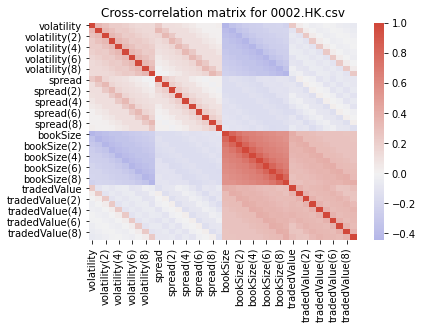

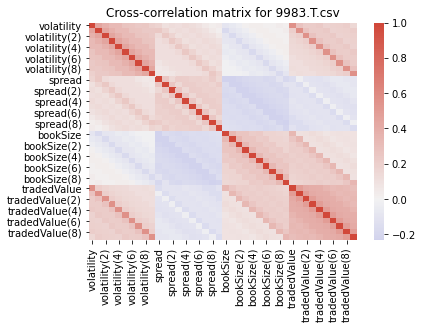

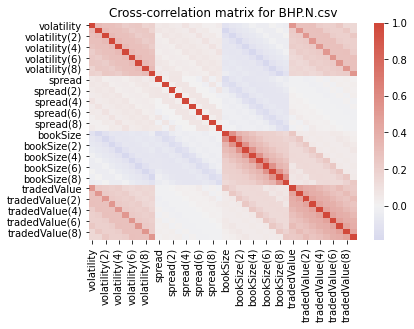

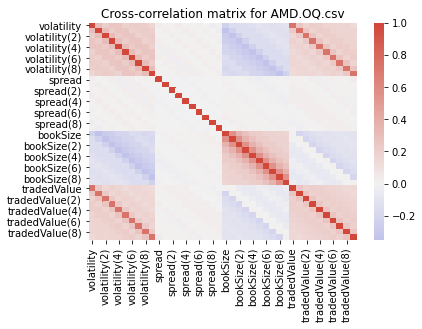

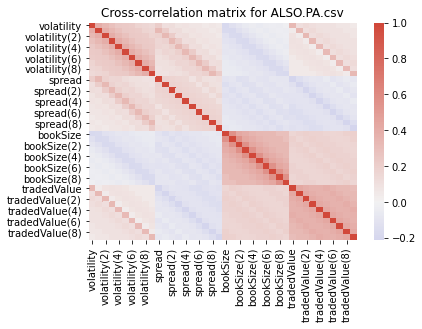

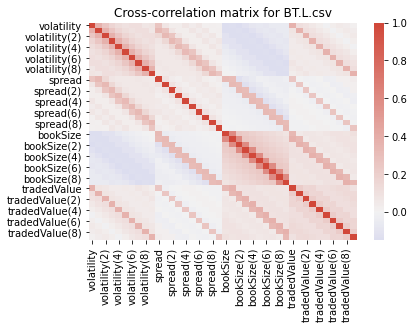

In [ ]:
donnees=['0002.HK.csv','9983.T.csv','BHP.N.csv','AMD.OQ.csv','ALSO.PA.csv','BT.L.csv']
lag=10
c=correlation(donnees,lag) 
for i in c:
    plt.figure()
    cmap = sn.diverging_palette(265, 15, as_cmap=True)
    sn.heatmap(c[i],cmap=cmap,center=0)
    plt.title(f'Cross-correlation matrix for {i}')

## Ordre VAR


In [ ]:
#VAR model lag
from itertools import combinations 
from collections import Counter   
def p_VAR(market):
    n=len(market)
    var={'spread':0,'tradedValue':0,'volatility':0,'bookSize':0}
    for i in market:

        var_i={'spread':0,'tradedValue':0,'volatility':0,'bookSize':0}
        
        df=market[i].copy()
        df['ts']=df['ts'].apply(lambda x: x[-8:-3])
        df=stationnaire(df)
        df=df[['spread','tradedValue','volatility','bookSize']]
        df.dropna(inplace=True)
        df.index=np.arange(len(df))
        df.loc[:,False==(df != df.iloc[0]).any()].values[0]*=2
        for j in range(2,5):
            for k in combinations(['spread','tradedValue','volatility','bookSize'],j):
                    data=df[list(k)]
                    model=VAR(data)
                    results = model.fit(maxlags=50, ic='bic')
                    p=results.k_ar
                    for l in k:
                        var_i[l]+=p/(6*n)
        var=dict(Counter(var)+Counter(var_i))
        
    return(var)

p_VAR(HK_stocks)

{'bookSize': 2.396551724137931,
 'spread': 2.32183908045977,
 'tradedValue': 3.126436781609195,
 'volatility': 2.4310344827586206}

In [ ]:
p_HK=p_VAR(HK_stocks)
p_T=p_VAR(T_stocks)
p_N=p_VAR(N_stocks)
p_OQ=p_VAR(OQ_stocks)
p_PA=p_VAR(PA_stocks)
p_L=p_VAR(L_stocks)

In [ ]:




p_HK1=pd.DataFrame(p_HK,index=['HK']).T
p_T1=pd.DataFrame(p_T,index=['T']).T
p_N1=pd.DataFrame(p_N,index=['N']).T
p_OQ1=pd.DataFrame(p_OQ,index=['OQ']).T
p_PA1=pd.DataFrame(p_PA,index=['PA']).T
p_L1=pd.DataFrame(p_L,index=['L']).T



In [ ]:
table=pd.concat([p_HK1,p_T1,p_N1,p_OQ1,p_PA1,p_L1],axis=1)
table

,HK,T,N,OQ,PA,L
spread,2.321839,3.130952,3.160256,3.302083,4.263889,2.106667
tradedValue,3.126437,3.523810,3.506410,3.755208,4.518519,2.546667
volatility,2.431034,3.279762,3.435897,3.473958,4.370370,2.280000
bookSize,2.396552,3.220238,3.455128,3.437500,4.416667,2.360000
